# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-05-21 06:00:57--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  21.9MB/s    in 9.0s    

2023-05-21 06:01:06 (19.3 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2023-05-21 06:01:06--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  31.5MB/s    in 1.9s    

2023-05-21 06:01:08 (31.5 MB/s) - ‘test_32x32.mat’ saved [64275384/

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_num = 0
    total_num = 0
    for data in loader:
        x, y = data
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)

        _, idx = torch.max(prediction, 1)
        correct_num += torch.sum(idx == y_gpu)
        total_num += y.shape[0]
    
    return correct_num / total_num

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

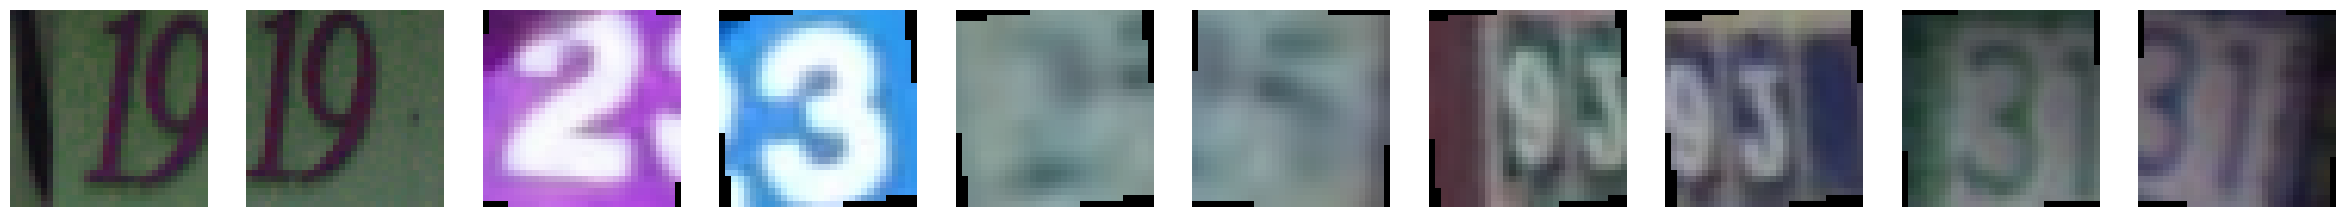

In [ ]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', transform=tfs)

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose

batch_size = 64

new_data_aug = dset.SVHN('./', transform=tfs)

data_size = new_data_aug.data.shape[0]
val_split = 0.2
indices = list(range(data_size))
np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices)

train_loader_aug = torch.utils.data.DataLoader(new_data_aug, batch_size=batch_size, 
                                           sampler=train_sampler)

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_loader_aug, val_loader, loss, optimizer, 5)

Average loss: 0.593524, Train accuracy: 0.818215, Val accuracy: 0.837554
Average loss: 0.542338, Train accuracy: 0.835797, Val accuracy: 0.843355
Average loss: 0.517212, Train accuracy: 0.843373, Val accuracy: 0.866016
Average loss: 0.501129, Train accuracy: 0.848260, Val accuracy: 0.859464
Average loss: 0.488084, Train accuracy: 0.852082, Val accuracy: 0.870384


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),    
    Flattener(),
    nn.Linear(400, 120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    nn.LogSoftmax(dim=-1)
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', transform=tfs)

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.626300, Train accuracy: 0.438770, Val accuracy: 0.719951
Average loss: 0.768369, Train accuracy: 0.764623, Val accuracy: 0.806839
Average loss: 0.640800, Train accuracy: 0.805124, Val accuracy: 0.816804
Average loss: 0.586074, Train accuracy: 0.821751, Val accuracy: 0.825541
Average loss: 0.544728, Train accuracy: 0.835497, Val accuracy: 0.845744
Average loss: 0.523006, Train accuracy: 0.842158, Val accuracy: 0.852570
Average loss: 0.501930, Train accuracy: 0.848328, Val accuracy: 0.843014
Average loss: 0.493500, Train accuracy: 0.851550, Val accuracy: 0.871135
Average loss: 0.483666, Train accuracy: 0.855126, Val accuracy: 0.877483
Average loss: 0.467545, Train accuracy: 0.859781, Val accuracy: 0.871272


# Подбор гиперпараметров

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 2, 3]
regs = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size_scheduler, gamma_scheduler):    
    loss_history = []
    train_history = []
    val_history = []

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size_scheduler, gamma=gamma_scheduler)   

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        if epoch != 0:
            scheduler.step()
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!
for _, lr in enumerate(learning_rates):
    for _, epochs in enumerate(anneal_epochs):
        for _, reg in enumerate(regs):
            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg)

            print(f'\nlearning_rate: {lr}   aneal_epochs: {epochs}   weight_decay: {reg}')
            loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 5, epochs, anneal_coeff)

            run_record[Hyperparams(lr, epochs, reg)] = RunResult(lenet_model, train_history, val_history, val_history[-1])


# TODO: Your code here!


learning_rate: 0.1   aneal_epochs: 1   weight_decay: 0.001
Average loss: 0.908358, Train accuracy: 0.720259, Val accuracy: 0.755512
Average loss: 0.738686, Train accuracy: 0.773196, Val accuracy: 0.791823
Average loss: 0.700602, Train accuracy: 0.785440, Val accuracy: 0.801242
Average loss: 0.689442, Train accuracy: 0.787638, Val accuracy: 0.802334
Average loss: 0.690843, Train accuracy: 0.788689, Val accuracy: 0.803085

learning_rate: 0.1   aneal_epochs: 1   weight_decay: 0.0001
Average loss: 0.906086, Train accuracy: 0.719863, Val accuracy: 0.748618
Average loss: 0.729819, Train accuracy: 0.775257, Val accuracy: 0.791072
Average loss: 0.686177, Train accuracy: 0.787652, Val accuracy: 0.802812
Average loss: 0.680131, Train accuracy: 0.791583, Val accuracy: 0.804996
Average loss: 0.678821, Train accuracy: 0.791556, Val accuracy: 0.804655

learning_rate: 0.1   aneal_epochs: 1   weight_decay: 1e-05
Average loss: 0.895089, Train accuracy: 0.724258, Val accuracy: 0.751689
Average loss: 0.

KeyboardInterrupt: ignored

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.84, best hyperparams: Hyperparams(learning_rate=0.001, anneal_epochs=1, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.BatchNorm2d(6),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),
    nn.Conv2d(6, 16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2),    
    Flattener(),
    nn.Linear(400, 120),
    nn.BatchNorm2d(120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.BatchNorm2d(84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10),
    # nn.LogSoftmax(dim=-1)
          )
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)


loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(best_model.parameters(), lr=1e-3, weight_decay=1e-3)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 10, 1, 0.9)

Average loss: 0.564071, Train accuracy: 0.826337, Val accuracy: 0.837008
Average loss: 0.562074, Train accuracy: 0.828399, Val accuracy: 0.836939
Average loss: 0.563961, Train accuracy: 0.826269, Val accuracy: 0.836871
Average loss: 0.563728, Train accuracy: 0.826583, Val accuracy: 0.836530
Average loss: 0.562420, Train accuracy: 0.828453, Val accuracy: 0.837758
Average loss: 0.561960, Train accuracy: 0.827839, Val accuracy: 0.837008


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
# TODO Write the code to compute accuracy on test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

RuntimeError: ignored